<a href="https://colab.research.google.com/github/kshitijd20/course-content/blob/dataloaders_kd/projects/fMRI/load_bonner_navigational_affordances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loader

## Summary
Here we will load data from Bonner and Epstein, 2017 [1]. The data consist of fMRI responses to indoor scenes from scene selective regions (also whole brain) and navigational affordance behavioral responses in the form of representational dissimilarity matrices (RDMs) .




## Representational Similarity Analysis (RSA) [2]
RSA is a method to relate signals
from different source spaces (such as behavior, neural
responses, DNN activations) by abstracting signals from
separate source spaces into a common similarity space. For
this, in each source space, condition-specific responses are
compared to each other for dissimilarity (e.g., by calculating
Euclidean distances between signals), and the values are
aggregated in so-called representational dissimilarity matrices (RDMs) indexed in rows and columns by the conditions
compared. RDMs thus summarize the representational
geometry of the source space signals. Different from source
space signals themselves, RDMs from different sources
spaces are directly comparable to each other for similarity
and thus can relate signals from different spaces 

The figure below illustrates how RSA can be applied to different problems by comparing RDMs of different modalities/species.

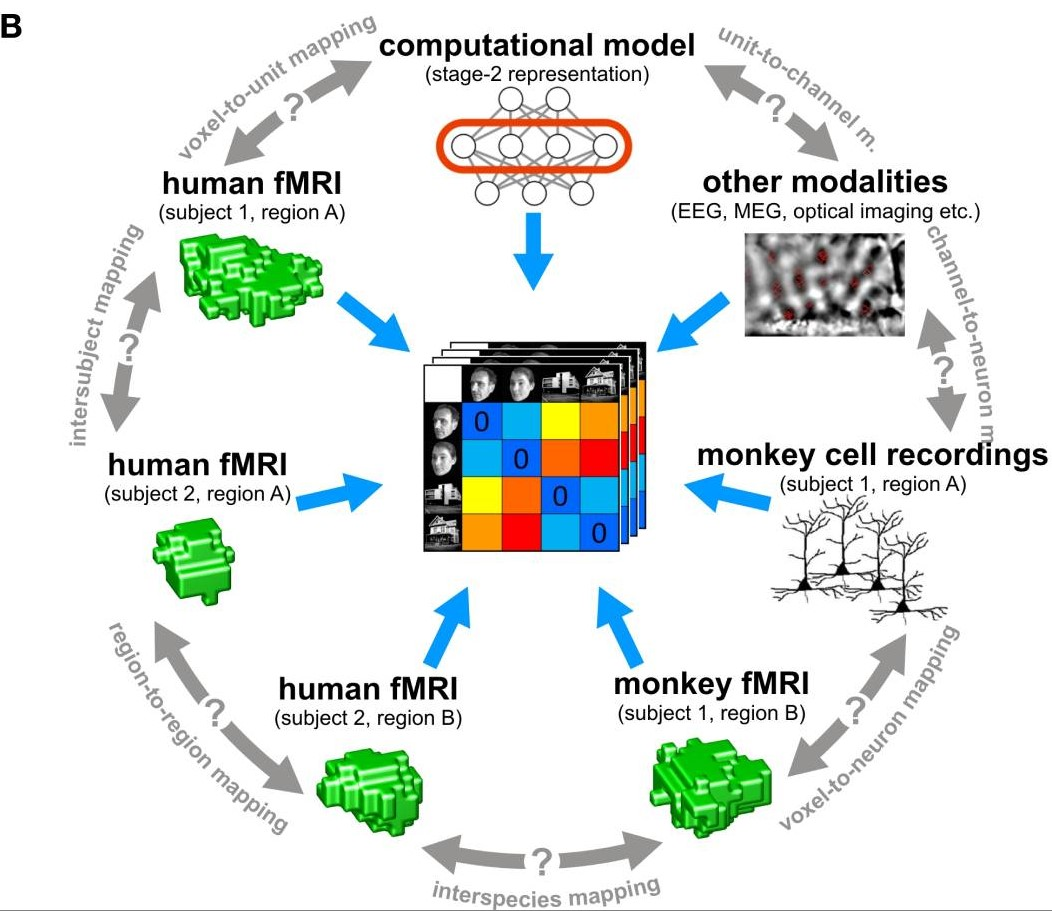

## Data from Bonner and Epstein
There are 50 images of indoor scene in this dataset. These images were used to collect fMRI and behavioral responses to investigate coding of navigational affordances in the human visual system.



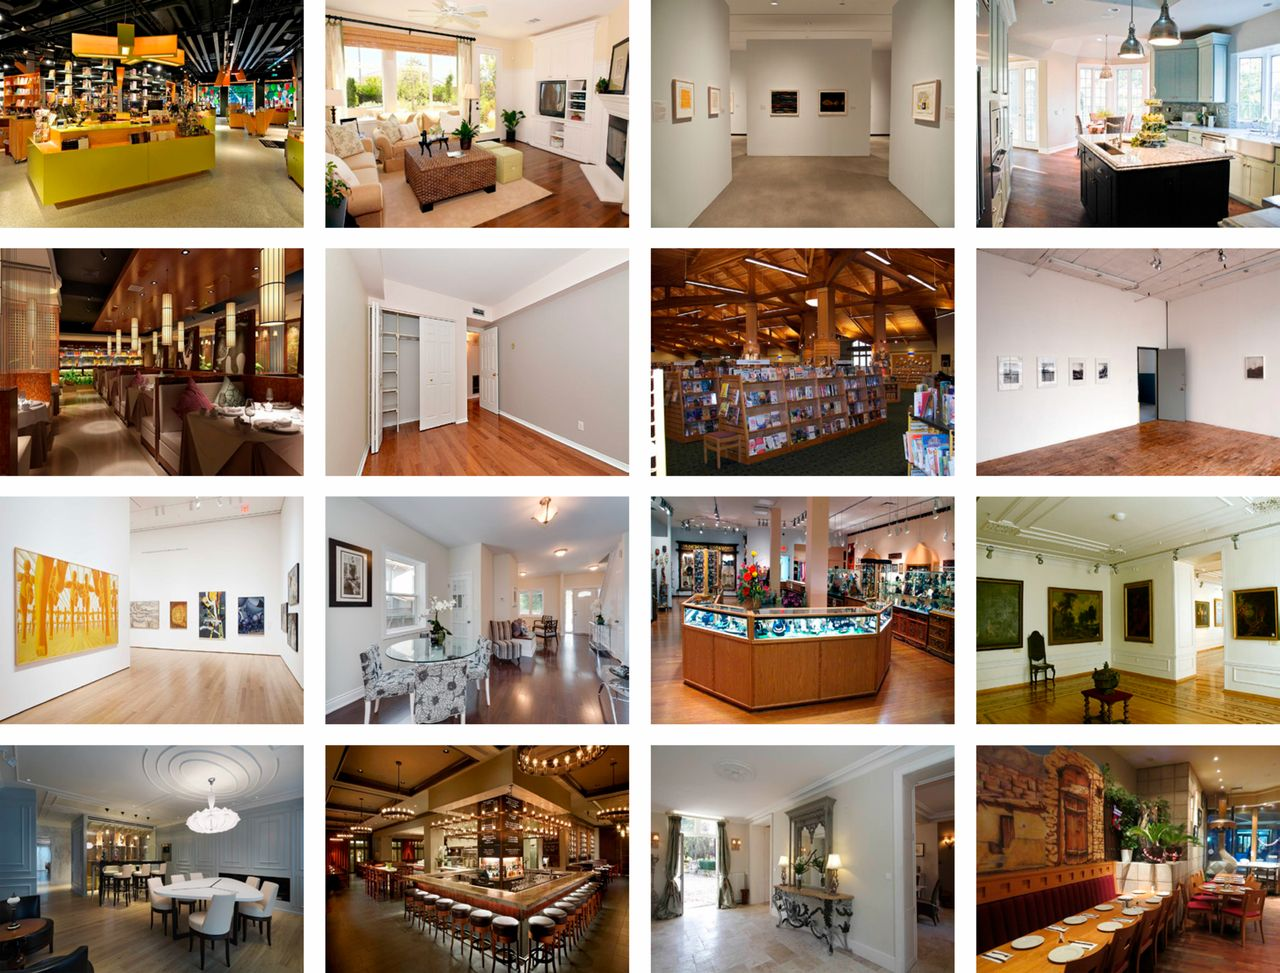

The images above show examples of complex, natural environments used as stimuli. All images were eye-level photographs of indoor environments with clear navigational paths extending from the implied viewing position.



In [ ]:
#@title Data download
%%capture
!wget -qO rdms.zip https://osf.io/dsnq6/download
!unzip -o rdms
!wget -qO affordances.zip https://osf.io/zcgub/download
!unzip -o affordances


In [ ]:
%%capture
!pip install nilearn

In [ ]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from tqdm import tqdm
from PIL import Image
from torchvision import transforms as trn
import scipy.io as sio
import h5py
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

def loadmat(matfile):
    """Function to load .mat files.
    Parameters
    ----------
    matfile : str
        path to `matfile` containing fMRI data for a given trial.
    Returns
    -------
    dict
        dictionary containing data in key 'vol' for a given trial.
    """
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

## fMRI RDMs

The fMRI data provided is available in form of RDMs. The regions of interest (ROI) investigated include two scene selective regions: parahippocampal place area (PPA) and occipital place area (OPA). If you are interested please watch a brief [video from Nancy Kanwisher](https://www.youtube.com/watch?v=EWK_hLrytQI) about these ROIs. Early visual cortex (EVC) RDM is also provided.  

In [ ]:
#@title loading fMRI RDMs
# Enter ROI field
ROI = 'EVC' #@param ["OPA", "PPA","EVC"]

# Load ROI RDM (num_stimulus x num_stimulus numpy array)
ROI_RDM = loadmat(ROI+".mat")["rdm"]

# Since the matrix is symmetric we set upper triangular values to NaN
ROI_RDM[np.triu_indices(ROI_RDM.shape[0], 1)] = np.nan

# plot the RDM
plt.imshow(ROI_RDM,\
           cmap="bwr")
plt.title(ROI + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Euclidean distance', rotation=270)

## Navigational affordance (behavioral) RDM
To measure the navigational affordances, subjects indicated with a computer mouse the paths that they would take to walk through each environment starting from the bottom of the image. From these responses, probabilistic maps of the navigational paths through each scene were created. Then  histograms of these navigational probability measurements in one-degree angular bins over a range of directions radiating from the starting point of the paths were constructed. These histograms approximate a probabilistic affordance map of potential navigational paths radiating from the perspective of the viewer.

RDM for the navigational-affordance model were constructed through pairwise comparisons of the affordance histograms.

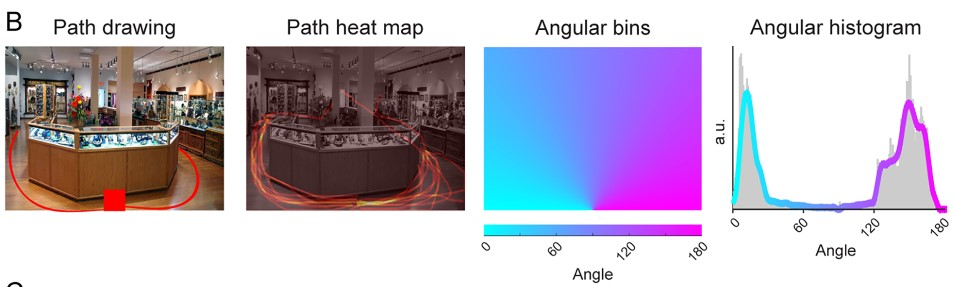

### Load and plot trajectories data

`Trajs.mat` contain data on the trajectories drawn by subjects during the evaluation phase before main experiment. The data is organised like `[n_images, heigth, width, n_evaluators]` There is a data on 173 images, of which 50 were presented to the participants. The filenames are stored as  `dtype`.


In [10]:
trajs = loadmat('Trajs.mat')['Trajs']
fnames = trajs.dtype.names # filenames get loaded as custom dtypes due and type of array is initialy np.void due to peculiarites of how it was saved in Matlab.
trajs = np.asarray(trajs[0][0].tolist()) # turn np.void into float32
trajs.shape

(173, 384, 512, 10)

In [ ]:
fig, ax = plt.subplots(18, 10, figsize=(20,30))

vmax = np.max(np.sum(trajs, axis=-1)) # make all images share the same scale
for a, tr in enumerate(trajs):
    i = ax.flat[a].imshow(np.sum(tr, axis=-1), aspect='auto', vmin=0, vmax=vmax) # plot the sum of trajectories over evaluators
    if a !=0:
        ax.flat[a].set_axis_off() # leave axis only on the first subplot
    ax.flat[a].set_title(fnames[a])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
fig.colorbar(i, cax=cbar_ax);

`allPaths.mat` contains data on paths drawn during evaluation phase for images presented to participants. The paths are already summed between evaluators.

In [ ]:
paths = loadmat('allPaths.mat')
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for a in range(50):
    i = ax.flat[a].imshow(paths['allPaths'][:,:,a], aspect='auto', vmin=0, vmax=np.max(paths['allPaths']))
    if a !=0:
        ax.flat[a].set_axis_off()
        
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
fig.colorbar(i, cax=cbar_ax)

`binCounts.mat` contains angular histogram for all images, calculated as per [1].

In [3]:
angular_hist = loadmat('binCounts.mat')['binCounts']
angular_hist.shape

(173, 180)

In [ ]:
fig, ax = plt.subplots(18, 10, figsize=(20,30))

for a, tr in enumerate(trajs):
    i = ax.flat[a].bar(range(angular_hist.shape[1]), angular_hist[a])
    if a !=0:
        ax.flat[a].set_axis_off()
    ax.flat[a].set_title(fnames[a])
fig.show()

Subset affordances data for images used in the experiment and plot paths over images

    `fnames_exp` array of 50 strings 
    `trajs_exp` [50 images x height x width x 10 evaluators]
    `angular_hist_exp` angular histograms data with 1-degree bins, [50 images x 180 degrees]
the order of affordances and images is preserved


In [ ]:
stim_fnames = [a.split('.')[0] for a in os.listdir('stimuli')]
fnames_exp_mask = [True if a in stim_fnames else False for a in fnames] #  make a boolean mask to select trajectories for images, 

fnames_exp = np.array(fnames)[fnames_exp_mask] # same order as affordances
trajs_exp = trajs[fnames_exp_mask]
angular_hist_exp = angular_hist[fnames_exp_mask]

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))
for a in range(50):
    im = Image.open(f'stimuli/{fnames_exp[a]}.jpg')
    scaled_img = np.kron(np.sum(trajs_exp[a], axis=-1), np.ones((2,2))) # images are 1024*768
    i = ax.flat[a].imshow(im)
    ax.flat[a].imshow(scaled_img, alpha=0.6)
    ax.flat[a].set_title(fnames_exp[a])
    ax.flat[a].set_axis_off()    

# Load behavioral RDM

In [ ]:
#@title loading behavioral RDM

# Load ROI RDM (num_stimulus x num_stimulus numpy array)
behavioral_RDM = loadmat("NAM.mat")["rdm"]

# Since the matrix is symmetric we set upper triangular values to NaN
behavioral_RDM[np.triu_indices(behavioral_RDM.shape[0], 1)] = np.nan

# plot the RDM
plt.imshow(behavioral_RDM,\
           cmap="bwr")
plt.title("Navigational affordance RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Euclidean distance', rotation=270)

## Searchlight RDMs


In [ ]:
#@title Load searchlight RDM
all_sub_sl_rdm = np.load('all_sub_slrdms.npy')

Searchlight RDM is in shape *n_subjects x n_searchlights x n_images x n_images*

## Mapping searchlight result (random) to voxels

In [ ]:
#@title Searchlight utils
def readnii(niifile):
    """
    Load nifti file as numpy array
    """
    img = nib.load(niifile)
    img_np = np.array(img.dataobj)
    return img_np
def get_blocks(mask,sl_rad=1, max_blk_edge=10):
    """Divide the volume into a set of blocks
    Ignore blocks that have no active voxels in the mask
    Parameters
    ----------
    mask: a boolean 3D array which is true at every active voxel
    Returns
    -------
    list of tuples containing block information:
       - a triple containing top left point of the block and
       - a triple containing the size in voxels of the block
    """
    blocks = []
    outerblk = max_blk_edge + 2*sl_rad
    for i in range(0, mask.shape[0], max_blk_edge):
        for j in range(0, mask.shape[1], max_blk_edge):
            for k in range(0, mask.shape[2], max_blk_edge):
                block_shape = mask[i:i+outerblk,
                                   j:j+outerblk,
                                   k:k+outerblk
                                   ].shape
                if np.any(
                    mask[i+sl_rad:i+block_shape[0]-sl_rad,
                         j+sl_rad:j+block_shape[1]-sl_rad,
                         k+sl_rad:k+block_shape[2]-sl_rad]):
                    blocks.append(((i, j, k), block_shape))
    return blocks
def get_block_data( mat, block):
    """Retrieve a block from a 3D or 4D volume
    Parameters
    ----------
    mat: a 3D or 4D volume
    block: a tuple containing block information:
      - a triple containing the lowest-coordinate voxel in the block
      - a triple containing the size in voxels of the block
    Returns
    -------
    In the case of a 3D array, a 3D subarray at the block location
    In the case of a 4D array, a 4D subarray at the block location,
    including the entire fourth dimension.
    """
    (pt, sz) = block
    if len(mat.shape) == 3:
        return mat[pt[0]:pt[0]+sz[0],
                   pt[1]:pt[1]+sz[1],
                   pt[2]:pt[2]+sz[2]].copy()
    elif len(mat.shape) == 4:
        return mat[pt[0]:pt[0]+sz[0],
                   pt[1]:pt[1]+sz[1],
                   pt[2]:pt[2]+sz[2],
                   :].copy()

def blocks2sl(brain_mask,sl_result,sl_rad,max_blk_edge):
    """
    maps searchlight results in blocks to voxels
    """
    mask = readnii(brain_mask)
    blocks = get_blocks(mask,sl_rad=sl_rad,max_blk_edge=max_blk_edge)

    # Coalesce results
    outmat = np.empty(mask.shape, dtype=np.object).astype(np.float)

    for i in range(sl_result.shape[0]):
        pt = blocks[i][0]
        mat = blocks[i][1]
        coords = np.s_[
            pt[0]+sl_rad:pt[0]+sl_rad+mat[0],
            pt[1]+sl_rad:pt[1]+sl_rad+mat[1],
            pt[2]+sl_rad:pt[2]+sl_rad+mat[2]
        ]
        outmat[coords] = sl_result[i]
    return outmat
    
def save_searchlight_nii(brain_mask, data, save_path,\
                         sl_rad = 1, max_blk_edge = 2):
    """maps searchlight result to voxels and saves it as nifti file.

    Parameters
    ----------
    brain_mask : string
        path to nii file of brain mask
    data : np.array
        searchlight results to be mapped back on brain
    save_path : string
        path to save resulting searchlight nii file
    max_blk_edge : int
        searchlight parameter

    Returns
    -------
    None

    """
    img = nib.load(brain_mask)
    functional_map =  blocks2sl(brain_mask,data,sl_rad,max_blk_edge)
    task_specificity_map_nii = nib.Nifti1Image(functional_map, img.affine, img.header)
    nib.save(task_specificity_map_nii, save_path)
  

In [ ]:
#@title Mapping random searchlight results to brain for visualization

# number of searchlights
num_sl = all_sub_sl_rdm.shape[1]

# generate results using normal distribution
mean = 0
std = 1
random_sl_result = np.random.normal(mean, std, num_sl)

# map the searchlights into voxels and save results as nifti file
brain_mask = 'mask.nii'
nii_save_path = 'random_sl.nii'
brain_map = save_searchlight_nii(brain_mask,random_sl_result\
                                 ,nii_save_path)

In [ ]:
#@title Visualing random searchlight result
import nilearn
from nilearn import plotting
plotting.plot_glass_brain(nii_save_path,plot_abs=False,colorbar=True,
                          display_mode='lyr',cmap ="jet", threshold = 0.01)


# Example Analyses
Here we correlate Navigational Affordances model(NAM) RDM with fMRI RDMs to find out which brain region (ROI/searchlight) has representation similar to NAM.

##fMRI-behavior comparison (ROIs)
Here our goal is to find out which ROI has representation similar to NAM.

In [ ]:
#@title RDM Comparison functions

from scipy.stats import spearmanr

def RSA_spearman(rdm1,rdm2):
    """
    computes and returns the spearman correlation between lower triangular 
    part of the input rdms. We only need to compare either lower or upper 
    triangular part of the matrix as RDM is symmetric
    """
    # get lower triangular part of the RDM1 
    lt_rdm1 = get_lowertriangular(rdm1)
    # get lower triangular part of the RDM1 
    lt_rdm2 = get_lowertriangular(rdm2)
    # return Spearman's correlation between lower triangular part of rdm1 & rdm2
    return spearmanr(lt_rdm1, lt_rdm2)[0]

def get_lowertriangular(rdm):
    """
    returns lower triangular part of the matrix
    """
    num_conditions = rdm.shape[0]
    return rdm[np.tril_indices(num_conditions,-1)]

In [ ]:
ROIs = ["EVC","PPA","OPA"]
correlation = []

# Calculate correlation between ROI RDM and behavioral RDM for 3 ROIs
for ROI in ROIs:
  ROI_RDM = loadmat(ROI+".mat")["rdm"]
  correlation.append(RSA_spearman(behavioral_RDM,ROI_RDM))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

####### bar plot showing correlation between behavioral and ROI RDMs ###########
barWidth = 0.55
fig = plt.subplots(figsize =(12, 8))
br = np.arange(len(ROIs))
plt.bar(br, correlation, color ='gray', width = barWidth,
        edgecolor ='grey')
 
plt.xlabel('ROIs', fontweight ='bold', fontsize = 15)
plt.ylabel('Spearmans Correlation', fontweight ='bold', fontsize = 15)
# Adding Xticks
plt.xticks([r  for r in range(len(ROIs))], ROIs)
plt.ylim(0,0.6)
plt.title("fMRI-behavior comparison", fontweight ='bold', fontsize = 15)
plt.show()
################################################################################

## fMRI-behavior comparison (searchlight)
Here our goal is to find out which brain regions have representation similar to NAM by comparing behavioral RDM with searchlight RDMs over the whole brain.

In [ ]:
#@title Comparing behavioral RDM with searchlight RDM
#select subject
sub_id = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]


s = int(sub_id) - 1
# get number of subjects
num_subs = all_sub_sl_rdm.shape[0]
# get number of searchlights
num_sl = all_sub_sl_rdm.shape[1]

sub_sl_correlation = []
# Calculate correlation between searchlight RDM and behavioral RDM for all searchlights

for i in tqdm(range(num_sl)):
  sub_sl_correlation.append(RSA_spearman(behavioral_RDM,\
                                          all_sub_sl_rdm[s,i,:,:]))
  
# List to numpy array
sub_sl_correlation = np.array(sub_sl_correlation)

In [ ]:
#@title Mapping the searchlight results to brain for visualization
brain_mask = 'mask.nii'
nii_save_path = 'navigational_affordance_sl.nii'
brain_map = save_searchlight_nii(brain_mask,sub_sl_correlation\
                                 ,nii_save_path)

In [ ]:
#@title Visualing searchlight result
import nilearn
from nilearn import plotting
plotting.plot_glass_brain(nii_save_path,plot_abs=False,colorbar=True,
                          display_mode='lyr',cmap ="jet")

The images used in this experiment are in the *stimuli* directory. Using the images, one can also explore which artificial vision models have representation similar to navigational affordances,  or scene selective regions e.g. in [3].

# References
1.   [Coding of navigational affordances in the human visual system
. Bonner and Epstein, PNAS 2017](https://www.pnas.org/content/114/18/4793)
2.   [Representational similarity analysis – connecting the branches of systems neuroscience. Kriegeskorte et al. Front. Syst. Neurosci., 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)
3.  [Computational mechanisms underlying cortical responses to the affordance properties of visual scenes. Bonner and Epstein, PLOS Computational Biology 2018](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006111)



